# Analyse quantitative multibranche

In [1]:
# data analysis
import pandas as pd
pd.options.display.width=108
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3_unweighted, venn3
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{lmodern}']

# utils
from pathlib import Path

Définition des couleurs : 

In [2]:
c_pomona = tuple(val / 255 for val in [0, 92, 132])
c_terreazur = tuple(val / 255 for val in [0, 152, 170])
c_episaveurs = tuple(val / 255 for val in [255, 69, 0])
c_passionfroid = tuple(val / 255 for val in [109, 32, 124])
c_deliceetcreation = tuple(val / 255 for val in [97, 45, 28])
c_saveursdantoine = tuple(val / 255 for val in [156, 34, 63])

On charge les données d'un fichier exporté du système de gestion des branches RHD (SAP).

In [3]:
path = Path('..') / 'data' / 'export2020.csv'

types = {
    'material': 'object', 
    'branch': 'int',
    'plant': 'object',     
    'type': 'object',
    'designation': 'object',
    'del_mand': 'bool', 
    'del_plant': 'bool',
    'march_group': 'object', 
    'storage_cond': 'object',
    'hier': 'object',
}
df = pd.read_csv(path,
                 sep=';',
                 encoding='latin-1',
                 engine='python',
                 header=0,
                 skipfooter=1, # footer line with totals in export
                 dtype=types,
                 true_values=['X'], # for del_mand and del_plant
                 false_values=['', np.nan], # for del_mand and del_plant
                )
df = df[types.keys()] #filter and reorder columns

Parmi les colonnes conservées, on a : 
- le code article (material)

- le code de branche de création (branch).
    - 1: PassionFroid
    - 2: EpiSaveurs
    - 3: TerreAzur

- le code d'activation sur une branche (plant).
    - 1PPF: PassionFroid
    - 2PES: EpiSaveurs
    - 3PTA: TerreAzur

- le type d'article (type). Seuls ZNEG et ZPRE représententent des aricles de marchandises.
    - ZNEG: Négoce
    - ZPRE: Prestation
    - ZENG: Article d'engagement (fictif pour facturation)
    - ZEMB: Article d'emballage (ex: palette)
    - ZSER: Article de service 
- le libellé de l'article (designation)
- si l'article est marqué pour suppression pour toutes les branches (del_mand)
- si l'article est marqué pour suppression sur la branche mentionnée dans la colonne plant (del_plant).
- le groupe de marchandises (march_group) :
    - ZSURGE: Surgelés
    - ZFRAIS: Frais (PassionFroid)
    - ZEPI: Epicerie
    - ZBOI: Boissons
    - ZHYG: Hygiène et chimie
    - ZFLF: Fruits et légumes (TerreAzur)
    - ZPMF: Produits de la mer (TerreAzur)
    - ZFP: Fleurs et plantes
    - ZELAB: Produits élaborés (TerreAzur)
- la condition de stockage (storage_cond) :
    - FR: Frais (PassionFroid)
    - SU: Surgelé,
    - EP: Epicerie,
    - AL: Alcool
    - HY: Hygiène et chimie
    - FL: Fruits et légumes (TerreAzur)
    - FP: Fleurs et plantes
    - MA: Marée
    - SA: Saurisserie (produits élaborés de la mer)
    - SE: Articles de Service
    - PL: Articles de publicité
- la hiérarchie produit (hier). Un plan de classement sur 6 niveaux, représentés par 2 caractères numériques chacun.

On crée une nouvelle feature qui correspond au niveau 1 de la hiérarchie produit.

In [4]:
# Creation of first level of product hierarchy
df.loc[:, 'hier1'] = df.hier.str[:2]

On définit un dictionnaire permettant de rappeler les libellés long des divers codes présents dans le dataset.

In [5]:
# Label names
lab = {'type': 'Type de produit',
       'march_group': 'Groupe de marchandises',
       'storage_cond': 'Condition de stockage',
       'hier1': 'Niveau 1 hiérarchie produit',
       '1PPF': 'PassionFroid',
       '2PES': 'EpiSaveurs',
       '3PTA': 'TerreAzur',
       'ZNEG': 'Article de négoce',
       'ZPRE': 'Article de prestation',
       'ZSURGE': 'Surgelés',
       'ZFRAIS': 'Frais',
       'ZEPI': 'Epicerie',
       'ZBOI': 'Boissons',
       'ZHYG': 'Hygiène', 
       'ZFLF': 'Fruits et Légumes',
       'ZPMF': 'Produits de la mer',
       'ZELAB': 'Produits élaborés', 
       'ZFP': 'Fleurs et plantes',
       'ZAUTRE': 'Autres',
       'SU': 'Surgelés',
       'FR': 'Frais', 
       'EP': 'Epicerie',
       'AL': 'Alcool',
       'HY': 'Hygiène',
       'FL': 'Fruits et légumes',
       'MA': 'Marée',
       'FP': 'Fleurs et plantes',
       'SA': 'Saurisserie',
       'PL': 'Publicié',
       '10': 'Beurre, oeufs, fromage',
       '20': 'Elaborés',
       '30': 'Garnitures et fruits',
       '40': 'Produits carnés', 
       '50': 'Produits de la mer',
       '60': 'Consommables',
       '70': 'Emballage',
       '80': 'Publicité sur le lieu de vente',
       '83': 'Epicerie',
       '85': 'Liquides',
       '87': 'Hygiène et entretien',
       '90': 'Services',
       '92': 'Fruits',
       '94': 'Légumes',
       '96': 'Produits de la mer Frais',
       '98': 'Fleurs - plantes',
      }

In [6]:
df.loc[[5000, 90000, 100000, 130000, 110000] , :]

,material,branch,plant,type,designation,del_mand,del_plant,march_group,storage_cond,hier,hier1
5000,15712,2,2PES,ZNEG,PSVNX CERN BRISURE S/AZ SAC 1KGX12 CERNO,True,True,ZEPI,EP,832020500505,83
90000,153086,3,3PTA,ZNEG,MANGUE KENT 351/550G PAD 12F DELIC BR°,False,False,ZFLF,FL,920518010405,92
100000,165387,1,1PPF,ZNEG,SALADE PLT 1KGX12 HAMAL,False,False,ZFRAIS,FR,202520150505,20
130000,203582,1,1PPF,ZPRE,EFFILOCHE BOEUF BARBACOA (2KGX6)/12KG CS,False,False,ZSURGE,SU,401015051505,40
110000,177238,2,2PES,ZNEG,COMP POIRE ALL BIO BTE 5/1X3 STM,False,False,ZEPI,EP,832005451505,83


On va définir deux masques, permettant de filtrer : 
- les articles actifs (i.e. non supprimé niveau mandant ni branche)
- les articles actifs de marchandises (i.e. qui ne sont pas des articles "spéciaux")

In [7]:
active_mask = ~df.del_mand & ~df.del_plant
active_march_mask = active_mask & df.type.isin(['ZNEG', 'ZPRE'])

On peut calculer la volumétrie d'articles et la représenter comme un histogramme. Les données de Délice et Création et Saveurs d'Antoine sont issue d'estimations fournies par le métier.

In [8]:
counts = df.groupby('plant')['material'].count().rename('Total')
filtered_counts = df[active_mask].groupby('plant')['material'].count().rename('Actifs')
filtered_counts2 = df[active_march_mask].groupby('plant')['material'].count().rename('Marchandises')

report = pd.concat([counts, filtered_counts, filtered_counts2], axis=1)
report.loc['Délice et Création', :] = [10000, np.nan, np.nan]
report.loc['Saveurs d\'Antoine', :] = [12000, np.nan, np.nan]
report.rename({'1PPF': 'PassionFroid', 
               '2PES': 'EpiSaveurs',
               '3PTA': 'TerreAzur'}, 
              inplace=True)
report.index.rename('Branche', inplace=True)
report = report.astype('Int64')
report.to_latex(Path('..') / 'tbls' / 'Articles par branche.tex',
                bold_rows=True,
                column_format='lccc',
                na_rep='-'
               )
report

,Total,Actifs,Marchandises
Branche,,,
PassionFroid,48478,24898,24554
EpiSaveurs,22498,12798,12241
TerreAzur,73804,62789,62710
Délice et Création,10000,NaN,NaN
Saveurs d'Antoine,12000,NaN,NaN


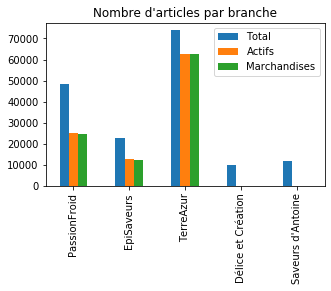

In [9]:
fig, ax = plt.subplots(figsize=(5,3))
report.plot(kind='bar', ax=ax)
ax.set_title('Nombre d\'articles par branche')
ax.set_xlabel('')
fig.savefig(Path('..') / 'img' / 'Articles par branche.png', bbox_inches='tight')

On peut également contruire le diagramme de Venn des articles pour les branches RHD :

In [10]:
# Filtering the dataset with active materials, and active merchandize materials
branch_sets = [set(df.loc[df.plant == branch_, 'material']) for branch_ in ['1PPF', '2PES', '3PTA']]

filtered_df = df.loc[active_mask]
filtered_sets = [set(filtered_df.loc[filtered_df.plant == branch_, 'material']) for branch_ in ['1PPF', '2PES', '3PTA']]

filtered_march_df = df.loc[active_march_mask]
filtered_march_sets = [set(filtered_march_df.loc[filtered_march_df.plant == branch_, 'material'])
                       for branch_ in ['1PPF', '2PES', '3PTA']] 

In [11]:
# This function is used to add label on Venn diagrams axes without showing spines
# (matplotlib-venn disables totally axis's, and spines need to get erased after
# axis's reactivation)
def labelize(ax, label, where='bottom', **kwargs):
    ax.set_axis_on()
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)
    if where == 'bottom':
        ax.set_xlabel(label, **kwargs)
    elif where == 'left':
        ax.set_ylabel(label, **kwargs)
    else:
        raise ValueError(f"Unexpected 'where' argument: {where}")

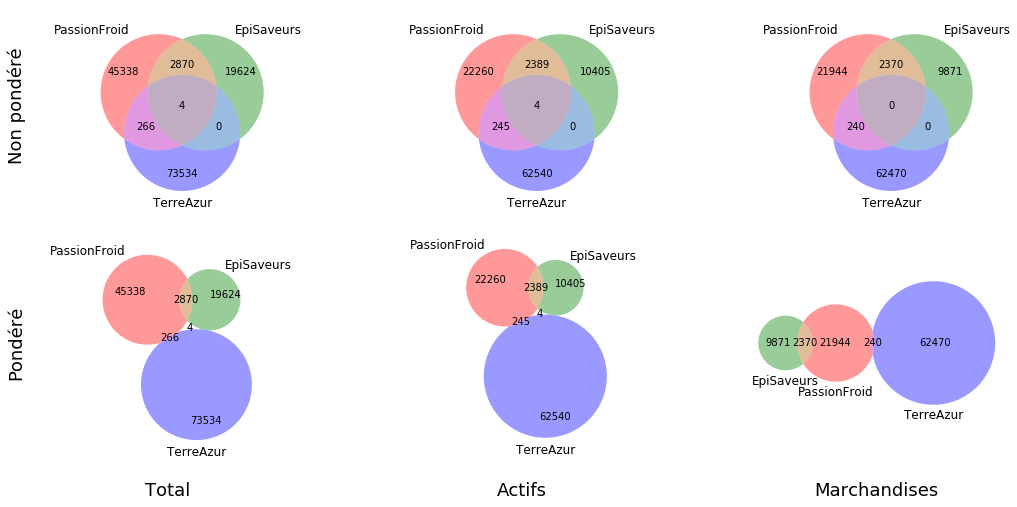

In [12]:
# Construction of the diagrams
scope = ['Total', 'Actifs', 'Marchandises']
types = ['Non pondéré', 'Pondéré']
nrows, ncols = len(types), len(scope)

fig, axs = plt.subplots(nrows, ncols, sharex='col', sharey='row', figsize=(18, 8))

for col, source_df in enumerate([branch_sets, filtered_sets, filtered_march_sets]):
    for row, venn_kind in enumerate([venn3_unweighted, venn3]):        
        venn_kind(source_df, set_labels=['PassionFroid', 'EpiSaveurs', 'TerreAzur'], ax=axs[row, col])
        if col == 0: 
            labelize(axs[row, col], types[row], where='left', fontsize=18, labelpad=10)
        if row == 1: 
            labelize(axs[row, col], scope[col], where='bottom', fontsize=18, labelpad=40)

# Ajusting the min and max of axes lims, as they are not the same by default
xmin = min([axs[row][col].get_xlim()[0] for row in range(nrows) for col in range(ncols)])
xmax = max([axs[row][col].get_xlim()[1] for row in range(nrows) for col in range(ncols)])
ymin = min([axs[row][col].get_ylim()[0] for row in range(nrows) for col in range(ncols)])
ymax = max([axs[row][col].get_ylim()[1] for row in range(nrows) for col in range(ncols)]) + 0.1

for row in range(nrows):
    for col in range(ncols):
        axs[row, col].set_xlim(xmin, xmax)
        axs[row, col].set_ylim(ymin, ymax)
        
# Saving the file to disk so that it is included in the report
fig.savefig(Path('..') / 'img' / 'Diagrammes de Venn articles.png', bbox_inches='tight')


On peut constater que les articles utilisés par les 3 branches RHD sont des articles "spéciaux".

In [13]:
df[df.material.isin(df.material.value_counts()[df.material.value_counts() >= 3].index)]

,material,branch,plant,type,designation,del_mand,del_plant,march_group,storage_cond,hier,hier1
144564,DECOMPTE,1,2PES,ZSER,ARTICLE DE DECOMPTE CONDITIONS ARRIERES,False,False,ZAUTRE,NaN,900505050505,90
144565,DECOMPTE,1,3PTA,ZSER,ARTICLE DE DECOMPTE CONDITIONS ARRIERES,False,False,ZAUTRE,NaN,900505050505,90
144566,DECOMPTE,1,1PPF,ZSER,ARTICLE DE DECOMPTE CONDITIONS ARRIERES,False,False,ZAUTRE,NaN,900505050505,90
144612,FC41849,1,1PPF,ZSER,RÉGUL SURFACTURATION DÉCONDITIONNEMENT,False,False,ZAUTRE,NaN,900505050505,90
144613,FC41849,1,2PES,ZSER,RÉGUL SURFACTURATION DÉCONDITIONNEMENT,False,False,ZAUTRE,NaN,900505050505,90
144614,FC41849,1,3PTA,ZSER,RÉGUL SURFACTURATION DÉCONDITIONNEMENT,False,False,ZAUTRE,NaN,900505050505,90
144642,LOT_ENGT,1,1PPF,ZENG,LOT ENGAGEMENT,False,False,NaN,NaN,NaN,NaN
144643,LOT_ENGT,1,3PTA,ZENG,LOT ENGAGEMENT,False,False,NaN,NaN,NaN,NaN
144644,LOT_ENGT,1,2PES,ZENG,LOT ENGAGEMENT,False,False,NaN,NaN,NaN,NaN
144719,S_PALETTE_PERDUE,3,3PTA,ZEMB,PALETTE 80X120 PERDUE,False,False,ZAUTRE,NaN,700510050505,70


On peut ensuite essayer de représenter les comptages d'articles sur les diverses variables catégorielles.

In [14]:
# Definition of feature and order to show
features = {'type': None,
            'march_group': ['ZFRAIS', 'ZSURGE', 'ZEPI', 'ZHYG', 'ZBOI', 'ZFLF', 'ZPMF', 'ZELAB', 'ZFP'],
            'storage_cond': ['FR', 'SU', 'EP', 'HY', 'FL', 'MA', 'SA', 'FP', 'PL'], 
            'hier1': None,
           }

# Definition of color palette
palette = {'1PPF': c_passionfroid,
           '2PES': c_episaveurs,
           '3PTA': c_terreazur,
          }

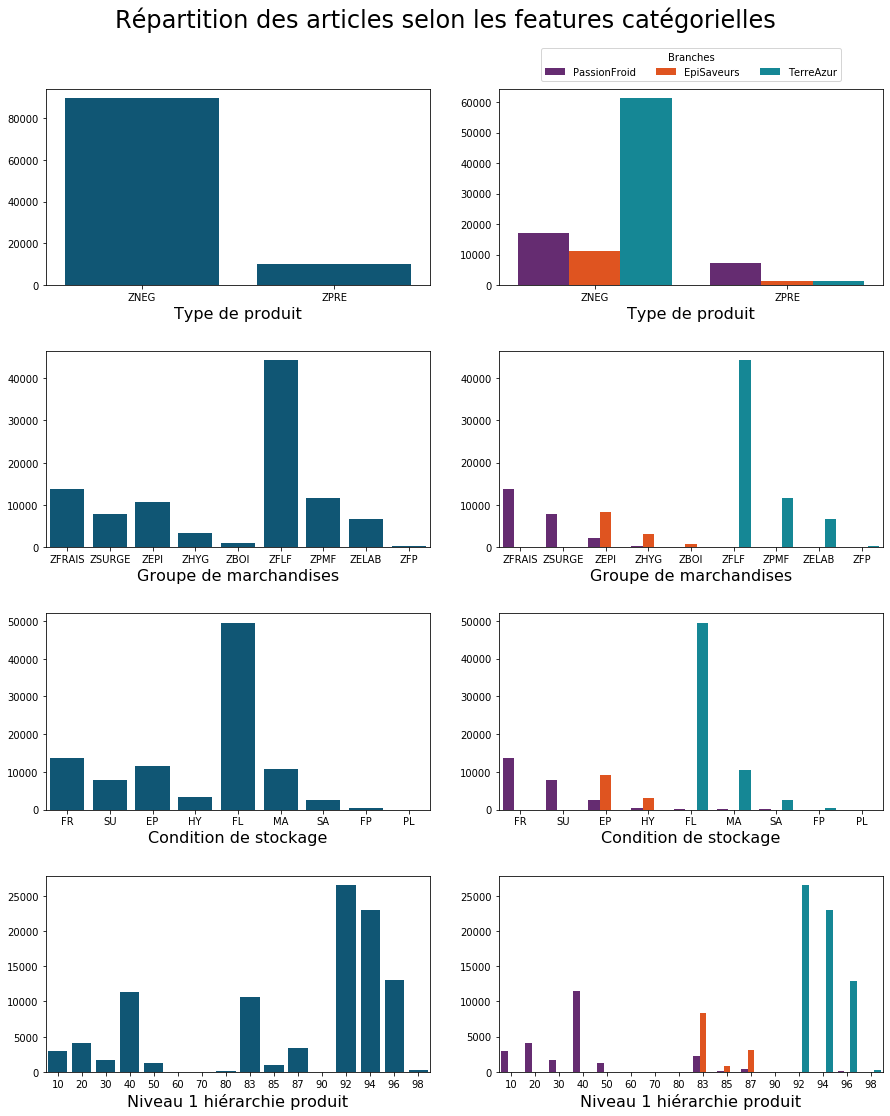

In [15]:
fig, axs = plt.subplots(nrows=len(features), ncols=2, figsize=(13, 15))
# for each feature, draw counts without and with hue
for idx, (feature, order) in enumerate(features.items()):
    # drawing without hue
    sns.countplot(data=df.loc[active_march_mask],
                  x=feature,
                  order=order,
                  ax=axs[idx][0],
                  color=c_pomona)
    # remove y label, and set x label to full length text
    axs[idx][0].set_ylabel('')
    axs[idx][0].set_xlabel(lab[feature], fontsize=16)
    # drawing with hue
    sns.countplot(data=df.loc[active_march_mask],
                  x=feature,
                  hue='plant',
                  order=order,
                  palette=palette,
                  ax=axs[idx][1],
                 ) 
    # remove y label, and set x label to full length text
    axs[idx][1].set_ylabel('')
    axs[idx][1].set_xlabel(lab[feature], fontsize=16)
    # hide legend for each axis
    axs[idx][1].legend().set_visible(False)

# redraw legend for the whole figure, above, centered and
# expanded 
handles, labels = axs[3][1].get_legend_handles_labels()
fig.legend(handles,
           [lab[label] for label in labels],
           ncol=len(handles),
           title='Branches',
           loc='center',
           bbox_to_anchor=(0, 1, 1, 0.25),
           bbox_transform=axs[0][1].transAxes,
           # mode='expand',
          )

# adding a title
fig.suptitle('Répartition des articles selon les features catégorielles',
             fontsize=24,
             y=1.025,
             va='bottom',
            )

# adding padding between plots
fig.tight_layout(pad=3.0)

# saving to disk
fig.savefig(Path('..') / 'img' / 'Repartition articles categories.png', bbox_inches='tight')

In [24]:
def long_lab(label):
    if label in lab:
        return(label + ' - ' + lab[label])
    else:
        return(label)

for feature in features.keys():
    # Construct the pivot table for the feature
    piv = pd.pivot_table(df.loc[active_march_mask],
                         columns='plant',
                         index=feature,
                         values='material',
                         aggfunc='count',
                         fill_value=0,
                        )
    # Add a 'Total' column
    piv['Total'] = piv['1PPF'] + piv['2PES'] + piv['3PTA']
    
    # Changing 0s to '-'
    piv = piv.replace(0, '-')
    
    # Reorder indices so that they follow the order defined in
    # lab dictionary
    if np.all(piv.index.isin(lab.keys())): # check to avoid filtering piv!
        piv = piv.reindex([key for key in lab.keys() if key in piv.index])

    # Rename indices, columns and axes for pretty printing
    piv = (piv.rename(long_lab, axis=0)
              .rename(lab, axis=1)
              .rename_axis(lab[feature])
              .rename_axis('Branche', axis=1))
    print(piv)
    print('---------------------------------------------------------------')
    # Save to LaTeX format to be included in report
    piv.to_latex(Path('..') / 'tbls' / ('Repartition par ' + feature + '.tex'),
                 bold_rows=True,
                 column_format='lcccc',
                 na_rep='-',
                )

Branche                       PassionFroid  EpiSaveurs  TerreAzur  Total
Type de produit                                                         
ZNEG - Article de négoce             17166       11048      61273  89487
ZPRE - Article de prestation          7388        1193       1437  10018
---------------------------------------------------------------
Branche                   PassionFroid EpiSaveurs TerreAzur  Total
Groupe de marchandises                                            
ZSURGE - Surgelés                 7756          -         -   7756
ZFRAIS - Frais                   13785          6         4  13795
ZEPI - Epicerie                   2298       8305         -  10603
ZBOI - Boissons                    126        826         -    952
ZHYG - Hygiène                     350       3078         -   3428
ZFLF - Fruits et Légumes             4          -     44133  44137
ZPMF - Produits de la mer          142          -     11594  11736
ZELAB - Produits élaborés           91   